In [1]:
import pandas as pd
import pandas_ta as ta
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10
import boto3
from botocore.exceptions import NoCredentialsError
from skimpy import skim

In [213]:
from dotenv import load_dotenv
import os

In [2]:
# Modeling and Forecasting
# ==============================================================================
import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
import shap

/home/alexl/anaconda3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-09 21:17:32.026701: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-09 21:17:32.657400: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [218]:
# Initialise la session S3

aws_access_key_id = os.getenv('AWS_ACCESS_KEY_ID')
aws_secret_access_key = os.getenv('AWS_SECRET_ACCESS_KEY')

s3 = boto3.client('s3', aws_access_key_id=aws_access_key_id, 
                       aws_secret_access_key=aws_secret_access_key)

# Nom du bucket et fichier à uploader
BUCKET_NAME = 'projetcryptoalex'

In [215]:
def download_parquet_from_s3(bucket, file_name):
    try:
        s3.download_file(bucket, file_name, f'/tmp/{file_name}')
        return pd.read_parquet(f'/tmp/{file_name}')
    except Exception as e:
        print(f"Erreur de téléchargement depuis S3 : {e}")
        return pd.DataFrame()

In [216]:
df_init = download_parquet_from_s3(BUCKET_NAME, 'NEARUSDT.parquet')

In [204]:
df = df_init.copy()


In [205]:
columns = [
    'open_time', 'open', 'high', 'low', 'close', 'volume', 
    'close_time', 'quote_volume', 'count', 
    'taker_buy_volume', 'taker_buy_quote_volume', 'ignore'
]
df.columns = columns

In [206]:
df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')  # Convertir en datetime en millisecondes
df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')  # Convertir en datetime en millisecondes
 

In [207]:
df

,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore
0,2024-10-01 04:03:00,5.38500000,5.39800000,5.38500000,5.39800000,1881.60000000,2024-10-01 04:03:59.999,10150.73670000,92,1384.00000000,7466.57460000,0
1,2024-10-01 04:04:00,5.39900000,5.40400000,5.39700000,5.40300000,9219.80000000,2024-10-01 04:04:59.999,49799.32180000,197,6981.90000000,37712.84350000,0
2,2024-10-01 04:05:00,5.40200000,5.40500000,5.40000000,5.40300000,2494.50000000,2024-10-01 04:05:59.999,13475.55000000,140,858.70000000,4639.38200000,0
3,2024-10-01 04:06:00,5.40300000,5.42700000,5.40300000,5.42500000,21733.80000000,2024-10-01 04:06:59.999,117733.10910000,912,15005.60000000,81270.25330000,0
4,2024-10-01 04:07:00,5.42600000,5.43600000,5.42300000,5.42600000,20904.30000000,2024-10-01 04:07:59.999,113523.29690000,657,11376.80000000,61781.18390000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9823,2024-10-09 20:06:00,4.60800000,4.61100000,4.60600000,4.61000000,1082.50000000,2024-10-09 20:06:59.999,4987.36430000,32,1055.20000000,4861.57650000,0
9824,2024-10-09 20:07:00,4.61000000,4.61200000,4.59900000,4.60000000,2101.90000000,2024-10-09 20:07:59.999,9680.45150000,44,1398.30000000,6439.99850000,0
9825,2024-10-09 20:08:00,4.59900000,4.60200000,4.59900000,4.60100000,1237.20000000,2024-10-09 20:08:59.999,5692.11120000,44,689.60000000,3172.70710000,0
9826,2024-10-09 20:09:00,4.60100000,4.60200000,4.59800000,4.59900000,1273.80000000,2024-10-09 20:09:59.999,5859.88280000,37,77.60000000,357.03910000,0


matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


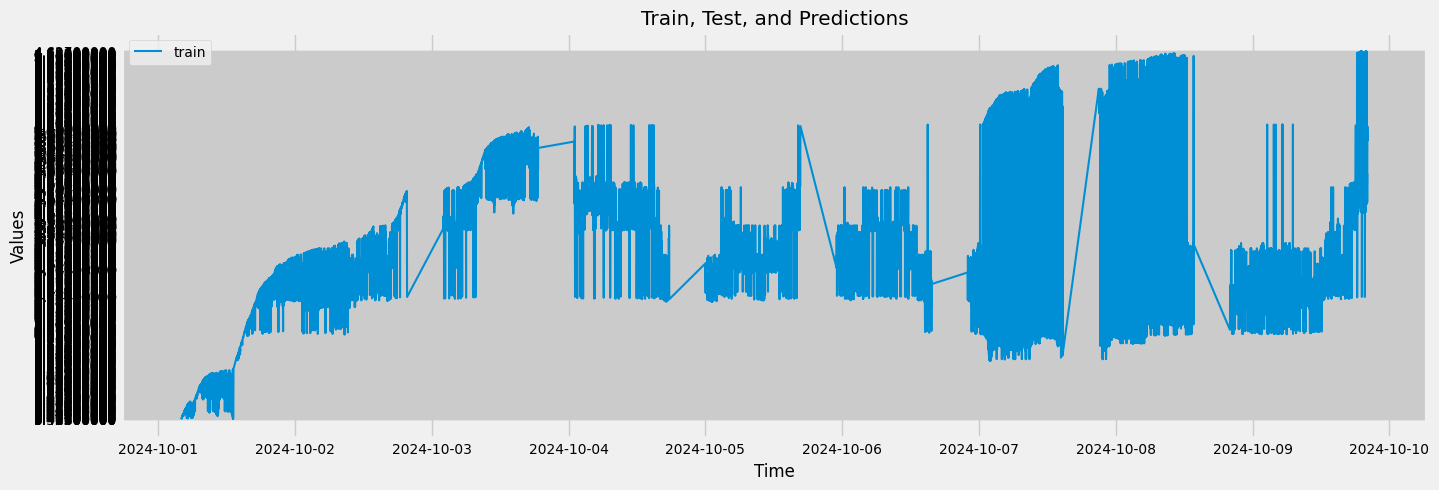

In [210]:
# Utiliser matplotlib pour tracer les données
plt.figure(figsize=(15, 5))
plt.plot(df.index, df.close.values, label='train')
plt.title('Train, Test, and Predictions')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

In [209]:
# Définir la colonne 'open_time' comme index
df.set_index('open_time', inplace=True)
# Assurer que l'index est trié dans l'ordre chronologique
df.sort_index(inplace=True)

In [168]:
# Convertir automatiquement les colonnes numériques en float
cols_to_convert = ['open', 'high', 'low', 'close', 'volume', 'quote_volume', 'taker_buy_volume', 'taker_buy_quote_volume']

# Appliquer la conversion pour ces colonnes
df[cols_to_convert] = df[cols_to_convert].astype(float)

In [169]:
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 9378   │ │ float64     │ 8     │                                                          │
│ │ Number of columns │ 11     │ │ datetime64  │ 1     │                                                          │
│ └───────────────────┴────────┘ │ int64       │ 1     │                                                          │
│                                │ string      │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name            ┃ NA  ┃ NA %  ┃ mean   ┃ sd      ┃ p0    ┃ p25   ┃ p50   ┃ p75   ┃ p100    ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩  │
│ │ open                   │   0 │     0 │   4.89 │  0.2261 │ 4.425 │ 4.739 │  4.84 │ 4.994 │    5.56 │ ▂▇▇▃▂▁ │  │
│ │ high                   │   0 │     0 │  4.895 │   0.226 │ 4.436 │ 4.743 │ 4.845 │ 4.999 │   5.565 │ ▂▇▇▃▁▁ │  │
│ │ low                    │   0 │     0 │  4.886 │  0.2262 │ 4.418 │ 4.736 │ 4.836 │  4.99 │   5.551 │ ▂▇▇▃▂▁ │  │
│ │ close                  │   0 │     0 │   4.89 │  0.2261 │ 4.425 │ 4.739 │  4.84 │ 4.994 │   5.561 │ ▂▇▇▃▂▁ │  │
│ │ volume                 │   0 │     0 │   8359 │   13640 │   7.9 │  1949 │  4329 │  9702 │  274900 │   ▇    │  │
│ │ quote_volume           │   0 │     0 │  40960 │   67220 │ 37.71 │  9545 │ 21170 │ 47490 │ 1336000 │   ▇    │  │
│ │ count                  │   0 │     0 │  234.4 │   279.1 │     2 │    76 │   147 │   289 │    4077 │   ▇    │  │
│ │ taker_buy_volume       │   0 │     0 │   4028 │    7384 │     0 │ 750.1 │  1875 │  4499 │  183900 │   ▇    │  │
│ │ taker_buy_quote_volume │   0 │     0 │  19740 │   36480 │     0 │  3685 │  9181 │ 21980 │  934700 │   ▇    │  │
│ └────────────────────────┴─────┴───────┴────────┴─────────┴───────┴───────┴───────┴───────┴─────────┴────────┘  │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓  │
│ ┃ column_name      ┃ NA   ┃ NA %   ┃ first                       ┃ last                       ┃ frequency    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩  │
│ │ close_time       │    0 │      0 │ 2024-10-01 04:03:59.999000  │ 2024-10-09 12:40:59.999000 │ None         │  │
│ └──────────────────┴──────┴────────┴─────────────────────────────┴────────────────────────────┴──────────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ ignore                    │       0 │          0 │  

In [170]:
df.isna().sum()

open                      0
high                      0
low                       0
close                     0
volume                    0
close_time                0
quote_volume              0
count                     0
taker_buy_volume          0
taker_buy_quote_volume    0
ignore                    0
dtype: int64

In [171]:
# 1. MACD
macd = ta.macd(df['close'], fast=12, slow=26, signal=9)
df = pd.concat([df, macd], axis=1)

df.isna().sum()

open                       0
high                       0
low                        0
close                      0
volume                     0
close_time                 0
quote_volume               0
count                      0
taker_buy_volume           0
taker_buy_quote_volume     0
ignore                     0
MACD_12_26_9              25
MACDh_12_26_9             33
MACDs_12_26_9             33
dtype: int64

In [173]:
# 2. RSI
df['RSI'] = ta.rsi(df['close'], length=14)
df.isna().sum()

open                       0
high                       0
low                        0
close                      0
volume                     0
close_time                 0
quote_volume               0
count                      0
taker_buy_volume           0
taker_buy_quote_volume     0
ignore                     0
MACD_12_26_9              25
MACDh_12_26_9             33
MACDs_12_26_9             33
RSI                       14
dtype: int64

In [175]:
df['SMA_50'] = ta.sma(df['close'], length=50)  # Moyenne mobile simple sur 50 périodes
df['EMA_20'] = ta.ema(df['close'], length=20)  # Moyenne mobile exponentielle sur 20 périodes
df.isna().sum()

open                       0
high                       0
low                        0
close                      0
volume                     0
close_time                 0
quote_volume               0
count                      0
taker_buy_volume           0
taker_buy_quote_volume     0
ignore                     0
MACD_12_26_9              25
MACDh_12_26_9             33
MACDs_12_26_9             33
RSI                       14
SMA_50                    49
EMA_20                    19
dtype: int64

In [176]:
# 4. Bollinger Bands
bollinger = ta.bbands(df['close'], length=20, std=2)
df = pd.concat([df, bollinger], axis=1)
df.isna().sum()

open                       0
high                       0
low                        0
close                      0
volume                     0
close_time                 0
quote_volume               0
count                      0
taker_buy_volume           0
taker_buy_quote_volume     0
ignore                     0
MACD_12_26_9              25
MACDh_12_26_9             33
MACDs_12_26_9             33
RSI                       14
SMA_50                    49
EMA_20                    19
BBL_20_2.0                19
BBM_20_2.0                19
BBU_20_2.0                19
BBB_20_2.0                19
BBP_20_2.0                19
dtype: int64

In [177]:
# 5. ADX
adx = ta.adx(df['high'], df['low'], df['close'], length=14)
df = pd.concat([df, adx], axis=1)
df.isna().sum()

open                       0
high                       0
low                        0
close                      0
volume                     0
close_time                 0
quote_volume               0
count                      0
taker_buy_volume           0
taker_buy_quote_volume     0
ignore                     0
MACD_12_26_9              25
MACDh_12_26_9             33
MACDs_12_26_9             33
RSI                       14
SMA_50                    49
EMA_20                    19
BBL_20_2.0                19
BBM_20_2.0                19
BBU_20_2.0                19
BBB_20_2.0                19
BBP_20_2.0                19
ADX_14                    27
DMP_14                    14
DMN_14                    14
dtype: int64

In [178]:
# 6. ATR
df['ATR'] = ta.atr(df['high'], df['low'], df['close'], length=14)
df.isna().sum()

open                       0
high                       0
low                        0
close                      0
volume                     0
close_time                 0
quote_volume               0
count                      0
taker_buy_volume           0
taker_buy_quote_volume     0
ignore                     0
MACD_12_26_9              25
MACDh_12_26_9             33
MACDs_12_26_9             33
RSI                       14
SMA_50                    49
EMA_20                    19
BBL_20_2.0                19
BBM_20_2.0                19
BBU_20_2.0                19
BBB_20_2.0                19
BBP_20_2.0                19
ADX_14                    27
DMP_14                    14
DMN_14                    14
ATR                       14
dtype: int64

In [156]:
# # 7. Ichimoku Cloud
# ichimoku_lead = ta.ichimoku(df['high'], df['low'], df['close'], tenkan=9, kijun=26, senkou=52)

# # Extraire les éléments du tuple
# ichimoku_df = pd.DataFrame(ichimoku_lead).rename(columns={0: 'ISA_9', 1: 'ISB_26', 2: 'ITS_9', 3: 'IKS_26', 4: 'ICS_26'})

# # Concaténer le résultat avec le DataFrame principal
# df = pd.concat([df, ichimoku_df], axis=1)

In [179]:
# 8. Stochastic Oscillator
stoch = ta.stoch(df['high'], df['low'], df['close'], k=14, d=3)
df = pd.concat([df, stoch], axis=1)
df.isna().sum()

open                       0
high                       0
low                        0
close                      0
volume                     0
close_time                 0
quote_volume               0
count                      0
taker_buy_volume           0
taker_buy_quote_volume     0
ignore                     0
MACD_12_26_9              25
MACDh_12_26_9             33
MACDs_12_26_9             33
RSI                       14
SMA_50                    49
EMA_20                    19
BBL_20_2.0                19
BBM_20_2.0                19
BBU_20_2.0                19
BBB_20_2.0                19
BBP_20_2.0                19
ADX_14                    27
DMP_14                    14
DMN_14                    14
ATR                       14
STOCHk_14_3_3             15
STOCHd_14_3_3             17
dtype: int64

In [158]:
# 9. VWAP
# df['VWAP'] = ta.vwap(df['high'], df['low'], df['close'], df['volume'])

In [180]:
# Calculer le Point Pivot (PP)
df['Pivot'] = (df['high'] + df['low'] + df['close']) / 3

# Calculer les Supports et Résistances
df['Resistance_1'] = 2 * df['Pivot'] - df['low']
df['Support_1'] = 2 * df['Pivot'] - df['high']
df['Resistance_2'] = df['Pivot'] + (df['high'] - df['low'])
df['Support_2'] = df['Pivot'] - (df['high'] - df['low'])
df['Resistance_3'] = df['high'] + 2 * (df['Pivot'] - df['low'])
df['Support_3'] = df['low'] - 2 * (df['high'] - df['Pivot'])
df.isna().sum()

open                       0
high                       0
low                        0
close                      0
volume                     0
close_time                 0
quote_volume               0
count                      0
taker_buy_volume           0
taker_buy_quote_volume     0
ignore                     0
MACD_12_26_9              25
MACDh_12_26_9             33
MACDs_12_26_9             33
RSI                       14
SMA_50                    49
EMA_20                    19
BBL_20_2.0                19
BBM_20_2.0                19
BBU_20_2.0                19
BBB_20_2.0                19
BBP_20_2.0                19
ADX_14                    27
DMP_14                    14
DMN_14                    14
ATR                       14
STOCHk_14_3_3             15
STOCHd_14_3_3             17
Pivot                      0
Resistance_1               0
Support_1                  0
Resistance_2               0
Support_2                  0
Resistance_3               0
Support_3     

In [181]:
df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S')
df.isna().sum()

open                       0
high                       0
low                        0
close                      0
volume                     0
close_time                 0
quote_volume               0
count                      0
taker_buy_volume           0
taker_buy_quote_volume     0
ignore                     0
MACD_12_26_9              25
MACDh_12_26_9             33
MACDs_12_26_9             33
RSI                       14
SMA_50                    49
EMA_20                    19
BBL_20_2.0                19
BBM_20_2.0                19
BBU_20_2.0                19
BBB_20_2.0                19
BBP_20_2.0                19
ADX_14                    27
DMP_14                    14
DMN_14                    14
ATR                       14
STOCHk_14_3_3             15
STOCHd_14_3_3             17
Pivot                      0
Resistance_1               0
Support_1                  0
Resistance_2               0
Support_2                  0
Resistance_3               0
Support_3     

In [182]:
df = df.asfreq('min')
df.isna().sum()

open                      2660
high                      2660
low                       2660
close                     2660
volume                    2660
close_time                2660
quote_volume              2660
count                     2660
taker_buy_volume          2660
taker_buy_quote_volume    2660
ignore                    2660
MACD_12_26_9              2685
MACDh_12_26_9             2693
MACDs_12_26_9             2693
RSI                       2674
SMA_50                    2709
EMA_20                    2679
BBL_20_2.0                2679
BBM_20_2.0                2679
BBU_20_2.0                2679
BBB_20_2.0                2679
BBP_20_2.0                2679
ADX_14                    2687
DMP_14                    2674
DMN_14                    2674
ATR                       2674
STOCHk_14_3_3             2675
STOCHd_14_3_3             2677
Pivot                     2660
Resistance_1              2660
Support_1                 2660
Resistance_2              2660
Support_

In [187]:
df=df.dropna()

In [188]:
df.isna().sum()

open                      0
high                      0
low                       0
close                     0
volume                    0
close_time                0
quote_volume              0
count                     0
taker_buy_volume          0
taker_buy_quote_volume    0
ignore                    0
MACD_12_26_9              0
MACDh_12_26_9             0
MACDs_12_26_9             0
RSI                       0
SMA_50                    0
EMA_20                    0
BBL_20_2.0                0
BBM_20_2.0                0
BBU_20_2.0                0
BBB_20_2.0                0
BBP_20_2.0                0
ADX_14                    0
DMP_14                    0
DMN_14                    0
ATR                       0
STOCHk_14_3_3             0
STOCHd_14_3_3             0
Pivot                     0
Resistance_1              0
Support_1                 0
Resistance_2              0
Support_2                 0
Resistance_3              0
Support_3                 0
dtype: int64

In [138]:
##############################################################################################################

In [189]:
####decallage de 30 minutes
y = df['close']
X = df.drop(['close', 'open', 'high', 'low'], axis=1)  # Ajustez selon vos besoins

In [190]:
y.isna().sum()

0

In [191]:
print(X.index.freq)

None


In [193]:
shift_steps = 30
y_shifted = y.shift(-shift_steps)

In [194]:
# Enlever les lignes sans valeurs valides après le décalage
X = X.iloc[:-shift_steps]
y_shifted = y_shifted.iloc[:-shift_steps]

In [195]:
# Diviser en train et test (sans mélanger l'ordre temporel)
X_train, X_test, y_train, y_test = train_test_split(X, y_shifted, test_size=0.05, shuffle=False)

In [196]:
# Conversion des colonnes datetime et catégories
datetime_columns = X_train.select_dtypes(include=['datetime64']).columns
for col in datetime_columns:
    X_train[col] = X_train[col].astype(int) / 10**9
    X_test[col] = X_test[col].astype(int) / 10**9

object_columns = X_train.select_dtypes(include=['object']).columns
for col in object_columns:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

category_columns = X_train.select_dtypes(include=['category']).columns
for col in category_columns:
    X_train[col] = X_train[col].cat.codes
    X_test[col] = X_test[col].cat.codes

In [197]:
from xgboost import XGBRegressor
forecaster = ForecasterAutoreg(
    regressor=XGBRegressor(
        n_estimators=300,           # Nombre d'arbres, à ajuster selon les performances
        learning_rate=0.1,          # Taux d'apprentissage, peut être ajusté
        max_depth=4,                # Profondeur maximale des arbres, ajuste selon les résultats
        random_state=123            # Garde la reproductibilité
    ),
    lags=19  # Utiliser les 50 lags comme spécifié
)

In [198]:
len(y_train)

8834

In [199]:
y_train.isna().sum()

0

In [200]:
# Entraîner le modèle
forecaster.fit(y=y_train, exog=X_train)


Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
`exog` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.


In [201]:
# Prédiction sur la période de test
predictions = forecaster.predict(steps=len(y_test), exog=X_test)

`last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
`exog` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.


TypeError: unsupported operand type(s) for +: 'Timestamp' and 'NoneType'

In [ ]:
predictions

In [ ]:
# Visualisation
fig, ax = plt.subplots(figsize=(15, 5))
y_train.plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test', color='yellow')
predictions.plot(ax=ax, label='predictions', color='red')
ax.legend()
plt.show()

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

MSE: 0.01860685037045468
RMSE: 0.1364069293344538
MAE: 0.12344875261339087


In [36]:
#####sans leakage

In [85]:
df

,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,...,ATR,STOCHk_14_3_3,STOCHd_14_3_3,Pivot,Resistance_1,Support_1,Resistance_2,Support_2,Resistance_3,Support_3
open_time,,,,,,,,,,,,,,,,,,,,,
2024-10-01 04:03:00,5.385,5.398,5.385,5.398,1881.6,2024-10-01 04:03:59.999,10150.7367,92,1384.0,7466.5746,...,NaN,NaN,NaN,5.393667,5.402333,5.389333,5.406667,5.380667,5.415333,5.376333
2024-10-01 04:04:00,5.399,5.404,5.397,5.403,9219.8,2024-10-01 04:04:59.999,49799.3218,197,6981.9,37712.8435,...,NaN,NaN,NaN,5.401333,5.405667,5.398667,5.408333,5.394333,5.412667,5.391667
2024-10-01 04:05:00,5.402,5.405,5.400,5.403,2494.5,2024-10-01 04:05:59.999,13475.5500,140,858.7,4639.3820,...,NaN,NaN,NaN,5.402667,5.405333,5.400333,5.407667,5.397667,5.410333,5.395333
2024-10-01 04:06:00,5.403,5.427,5.403,5.425,21733.8,2024-10-01 04:06:59.999,117733.1091,912,15005.6,81270.2533,...,NaN,NaN,NaN,5.418333,5.433667,5.409667,5.442333,5.394333,5.457667,5.385667
2024-10-01 04:07:00,5.426,5.436,5.423,5.426,20904.3,2024-10-01 04:07:59.999,113523.2969,657,11376.8,61781.1839,...,NaN,NaN,NaN,5.428333,5.433667,5.420667,5.441333,5.415333,5.446667,5.407667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-09 12:36:00,4.810,4.811,4.805,4.806,14834.1,2024-10-09 12:36:59.999,71315.0233,189,8040.2,38658.2114,...,0.008070,1.994048,6.348839,4.807333,4.809667,4.803667,4.813333,4.801333,4.815667,4.797667
2024-10-09 12:37:00,4.805,4.805,4.794,4.795,61196.4,2024-10-09 12:37:59.999,293713.6837,593,14532.2,69751.5885,...,0.008350,2.718685,2.329656,4.798000,4.802000,4.791000,4.809000,4.787000,4.813000,4.780000
2024-10-09 12:38:00,4.794,4.796,4.784,4.791,25418.8,2024-10-09 12:38:59.999,121708.2045,349,11085.3,53074.8103,...,0.008611,5.843685,3.518806,4.790333,4.796667,4.784667,4.802333,4.778333,4.808667,4.772667


In [38]:
###########################

In [24]:
# Séparation des données
train_size = int(len(df) * 0.95)
df_train = df.iloc[:train_size].copy()
df_test = df.iloc[train_size:].copy()

In [25]:
df_test

,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,...,ATR,STOCHk_14_3_3,STOCHd_14_3_3,Pivot,Resistance_1,Support_1,Resistance_2,Support_2,Resistance_3,Support_3
open_time,,,,,,,,,,,,,,,,,,,,,
2024-10-09 04:52:00,4.907,4.915,4.907,4.913,642.2,2024-10-09 04:52:59.999,3154.6869,29,473.8,2327.3493,...,0.006095,12.767043,6.350438,4.911667,4.916333,4.908333,4.919667,4.903667,4.924333,4.900333
2024-10-09 04:53:00,4.914,4.916,4.913,4.913,919.3,2024-10-09 04:53:59.999,4518.3933,31,866.1,4256.9847,...,0.005874,21.140059,12.577019,4.914000,4.915000,4.912000,4.917000,4.911000,4.918000,4.909000
2024-10-09 04:54:00,4.913,4.915,4.912,4.913,277.2,2024-10-09 04:54:59.999,1362.0091,30,14.1,69.2898,...,0.005668,28.585947,20.831016,4.913333,4.914667,4.911667,4.916333,4.910333,4.917667,4.908667
2024-10-09 04:55:00,4.911,4.913,4.909,4.910,919.2,2024-10-09 04:55:59.999,4513.8131,31,306.0,1502.4942,...,0.005549,27.976190,25.900732,4.910667,4.912333,4.908333,4.914667,4.906667,4.916333,4.904333
2024-10-09 04:56:00,4.910,4.913,4.909,4.911,422.6,2024-10-09 04:56:59.999,2074.8925,39,147.0,721.9159,...,0.005439,28.809524,28.457220,4.911000,4.913000,4.909000,4.915000,4.907000,4.917000,4.905000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-09 12:36:00,4.810,4.811,4.805,4.806,14834.1,2024-10-09 12:36:59.999,71315.0233,189,8040.2,38658.2114,...,0.008070,1.994048,6.348839,4.807333,4.809667,4.803667,4.813333,4.801333,4.815667,4.797667
2024-10-09 12:37:00,4.805,4.805,4.794,4.795,61196.4,2024-10-09 12:37:59.999,293713.6837,593,14532.2,69751.5885,...,0.008350,2.718685,2.329656,4.798000,4.802000,4.791000,4.809000,4.787000,4.813000,4.780000
2024-10-09 12:38:00,4.794,4.796,4.784,4.791,25418.8,2024-10-09 12:38:59.999,121708.2045,349,11085.3,53074.8103,...,0.008611,5.843685,3.518806,4.790333,4.796667,4.784667,4.802333,4.778333,4.808667,4.772667


In [26]:
# Définir la taille de la fenêtre nécessaire pour les calculs (par exemple, 26 pour MACD)
window_size = 26  # Ajustez selon le plus grand lag nécessaire pour vos indicateurs

# Étendre df_test avec les dernières lignes de df_train
extended_df_test = pd.concat([df_train.iloc[-window_size:], df_test])

In [27]:
# 1. MACD

##train
macd = ta.macd(df_train['close'], fast=12, slow=26, signal=9)
df_train = pd.concat([df_train, macd], axis=1)

###test
macd = ta.macd(extended_df_test['close'], fast=12, slow=26, signal=9)
extended_df_test = pd.concat([extended_df_test, macd], axis=1)

In [28]:
# 2. RSI
##train
df_train['RSI'] = ta.rsi(df_train['close'], length=14)
###test
extended_df_test['RSI'] = ta.rsi(extended_df_test['close'], length=14)

In [29]:
##train

df_train['SMA_50'] = ta.sma(df_train['close'], length=50)  # Moyenne mobile simple sur 50 périodes
df_train['EMA_20'] = ta.ema(df_train['close'], length=20)  # Moyenne mobile exponentielle sur 20 périodes

##test
extended_df_test['SMA_50'] = ta.sma(extended_df_test['close'], length=50)
extended_df_test['EMA_20'] = ta.ema(extended_df_test['close'], length=20)

In [30]:
# 4. Bollinger Bands
###train
bollinger = ta.bbands(df_train['close'], length=20, std=2)
df_train = pd.concat([df_train, bollinger], axis=1)

###test

bollinger = ta.bbands(extended_df_test['close'], length=20, std=2)
extended_df_test = pd.concat([extended_df_test, bollinger], axis=1)

In [31]:
# 5. ADX
###train

adx = ta.adx(df_train['high'], df_train['low'], df_train['close'], length=14)
df_train = pd.concat([df_train, adx], axis=1)
###test
adx = ta.adx(extended_df_test['high'], extended_df_test['low'], extended_df_test['close'], length=14)
extended_df_test = pd.concat([extended_df_test, adx], axis=1)

In [32]:
# 6. ATR

###train
df_train['ATR'] = ta.atr(df_train['high'], df_train['low'], df_train['close'], length=14)

###test
extended_df_test['ATR'] = ta.atr(extended_df_test['high'], extended_df_test['low'], extended_df_test['close'], length=14)


In [33]:
# 8. Stochastic Oscillator
###train
stoch = ta.stoch(df_train['high'], df_train['low'], df_train['close'], k=14, d=3)
df_train = pd.concat([df_train, stoch], axis=1)
###test
stoch = ta.stoch(extended_df_test['high'], extended_df_test['low'], extended_df_test['close'], k=14, d=3)
extended_df_test = pd.concat([extended_df_test, stoch], axis=1)


In [34]:
# Calculer le Point Pivot (PP)
###train
df_train['Pivot'] = (df_train['high'] + df_train['low'] + df_train['close']) / 3

# Calculer les Supports et Résistances
df_train['Resistance_1'] = 2 * df_train['Pivot'] - df_train['low']
df_train['Support_1'] = 2 * df_train['Pivot'] - df_train['high']
df_train['Resistance_2'] = df_train['Pivot'] + (df_train['high'] - df_train['low'])
df_train['Support_2'] = df_train['Pivot'] - (df_train['high'] - df_train['low'])
df_train['Resistance_3'] = df_train['high'] + 2 * (df_train['Pivot'] - df_train['low'])
df_train['Support_3'] = df_train['low'] - 2 * (df_train['high'] - df_train['Pivot'])

###test
extended_df_test['Pivot'] = (extended_df_test['high'] + extended_df_test['low'] + extended_df_test['close']) / 3
extended_df_test['Resistance_1'] = 2 * extended_df_test['Pivot'] - extended_df_test['low']
extended_df_test['Support_1'] = 2 * extended_df_test['Pivot'] - extended_df_test['high']
extended_df_test['Resistance_2'] = extended_df_test['Pivot'] + (extended_df_test['high'] - extended_df_test['low'])
extended_df_test['Support_2'] = extended_df_test['Pivot'] - (extended_df_test['high'] - extended_df_test['low'])
extended_df_test['Resistance_3'] = extended_df_test['high'] + 2 * (extended_df_test['Pivot'] - extended_df_test['low'])
extended_df_test['Support_3'] = extended_df_test['low'] - 2 * (extended_df_test['high'] - extended_df_test['Pivot'])


In [35]:
df_test = extended_df_test.iloc[window_size:].copy()

In [36]:
df_train.index = pd.to_datetime(df_train.index, format='%Y-%m-%d %H:%M:%S')
df_test.index = pd.to_datetime(df_test.index, format='%Y-%m-%d %H:%M:%S')

In [37]:
df_test=df_test.dropna()
df_train=df_train.dropna()


In [38]:
datetime_columns = df_test.select_dtypes(include=['datetime64']).columns
for col in datetime_columns:
    df_test[col] = df_test[col].astype(int) / 10**9
    df_train[col] = df_train[col].astype(int) / 10**9

In [39]:
# Convertir les colonnes object en catégories si nécessaire
object_columns = df_train.select_dtypes(include=['object']).columns
for col in object_columns:
    df_train[col] = df_train[col].astype('category')
    df_test[col] = df_test[col].astype('category')

# Convertir les catégories en codes numériques
category_columns = df_train.select_dtypes(include=['category']).columns
for col in category_columns:
    df_train[col] = df_train[col].cat.codes
    df_test[col] = df_test[col].cat.codes

In [40]:
y_train = df_train['close']
y_test = df_test['close']

X_train = df_train.drop(['close', 'open', 'high', 'low'], axis=1)  # Ajustez selon vos besoins
X_test = df_test.drop(['close', 'open', 'high', 'low'], axis=1)  # Ajustez selon vos besoins

In [41]:
import optuna
from xgboost import XGBRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.model_selection import cross_val_score
import numpy as np

In [42]:
from xgboost import XGBRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg


forecaster = ForecasterAutoreg(
    regressor=XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=16, random_state=123),
    lags=30  # Ajuster le nombre de lags selon vos besoins
)



In [43]:
# forecaster.fit(y=y_train, exog=X_train)
forecaster.fit(y=y_train)
predictions = forecaster.predict(steps=len(y_test))

Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
`last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.


In [44]:
# Aligner y_train et y_test
y_train_aligned, y_test_aligned = y_train.align(y_test, join='inner')

# Aligner y_train avec predictions
y_train_aligned, predictions_aligned = y_train_aligned.align(predictions, join='inner')


In [45]:
import optuna
from xgboost import XGBRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.model_selection import cross_val_score
import numpy as np

# Définir la fonction objectif pour Optuna
def objective(trial):
    # Suggérer le nombre de lags à utiliser
    lags = trial.suggest_int('lags', 5, 50)
    
    # Suggérer les hyperparamètres du modèle XGBRegressor
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 16),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1)
    }
    
    # Créer le modèle XGBRegressor avec les paramètres suggérés
    regressor = XGBRegressor(**param, random_state=123)
    
    # Créer le forecaster avec le nombre de lags suggéré
    forecaster = ForecasterAutoreg(regressor=regressor, lags=lags)
    
    # Ajuster le forecaster avec les données d'entraînement
    forecaster.fit(y=y_train)
    
    # Prédire pour les données de test
    predictions = forecaster.predict(steps=len(y_test))
    
    # Calculer l'erreur (par exemple, l'erreur quadratique moyenne)
    error = np.mean((predictions - y_test) ** 2)  # MSE
    
    return error


# Créer une étude Optuna pour optimiser les hyperparamètres et les lags
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2024-10-09 21:18:30,284] A new study created in memory with name: no-name-0e2f3fff-91aa-458c-b130-31f935a0e8e1
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
`last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
[W 2024-10-09 21:18:31,237] Trial 0 failed with 

[W 2024-10-09 21:18:52,292] Trial 6 failed with value nan.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
`last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
[W 2024-10-09 21:18:57,932] Trial 7 failed with parameters: {'lags': 45, 'n_estimators': 448, 'max_dept

[W 2024-10-09 21:19:38,586] Trial 13 failed with value nan.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
`last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
[W 2024-10-09 21:19:43,906] Trial 14 failed with parameters: {'lags': 27, 'n_estimators': 327, 'max_de

[W 2024-10-09 21:20:19,326] Trial 20 failed with value nan.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
`last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
[W 2024-10-09 21:20:22,832] Trial 21 failed with parameters: {'lags': 12, 'n_estimators': 546, 'max_de

[W 2024-10-09 21:20:48,659] Trial 27 failed with value nan.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
`last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
[W 2024-10-09 21:20:50,876] Trial 28 failed with parameters: {'lags': 28, 'n_estimators': 564, 'max_de

[W 2024-10-09 21:21:23,365] Trial 34 failed with value nan.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
`last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
[W 2024-10-09 21:21:27,812] Trial 35 failed with parameters: {'lags': 11, 'n_estimators': 981, 'max_de

[W 2024-10-09 21:21:47,334] Trial 41 failed with value nan.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
`last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
[W 2024-10-09 21:21:48,758] Trial 42 failed with parameters: {'lags': 28, 'n_estimators': 309, 'max_de

[W 2024-10-09 21:22:16,961] Trial 48 failed with value nan.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
`last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
[W 2024-10-09 21:22:26,485] Trial 49 failed with parameters: {'lags': 24, 'n_estimators': 989, 'max_de

In [46]:
# Afficher les meilleurs paramètres trouvés par Optuna
print("Meilleurs paramètres : ", study.best_params)

# Afficher la meilleure valeur de l'objectif (par exemple MSE)
print("Meilleure erreur (MSE) : ", study.best_value)

# Afficher le meilleur essai en détails
print("Meilleur essai : ", study.best_trial)


ValueError: No trials are completed yet.

In [ ]:
from xgboost import XGBRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg

# Récupérer les meilleurs paramètres trouvés par Optuna
best_params = study.best_params

# Créer le modèle XGBRegressor avec les meilleurs paramètres
best_model = XGBRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    random_state=123
)

# Créer le ForecasterAutoreg avec le nombre optimal de lags
forecaster = ForecasterAutoreg(
    regressor=best_model,
    lags=best_params['lags']
)

# Ajuster le forecaster avec les données d'entraînement
forecaster.fit(y=y_train)

# Calculer les prédictions pour les données de test
predictions = forecaster.predict(steps=len(y_test))

# Afficher les prédictions
print(predictions)


In [ ]:


# Utiliser matplotlib pour tracer les données
plt.figure(figsize=(15, 5))
plt.plot(y_train.index, y_train.values, label='train')
plt.plot(y_test.index, y_test.values, label='test', color='yellow')
plt.plot(predictions.index, predictions.values, label='predictions', color='red')
plt.title('Train, Test, and Predictions')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()




In [ ]:
# ==============================================================================
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(15,5))
y_train.plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test', color='yellow')
predictions.plot(ax=ax, label='predictions', color='red')
ax.legend();

In [ ]:

plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, predictions, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Prices')
plt.show()

In [67]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

MSE: 0.001958679750233656
RMSE: 0.044256974029339785
MAE: 0.03655981218814843
